In [116]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training logs
logs = pd.read_csv('./ppo/logs/progress.csv')

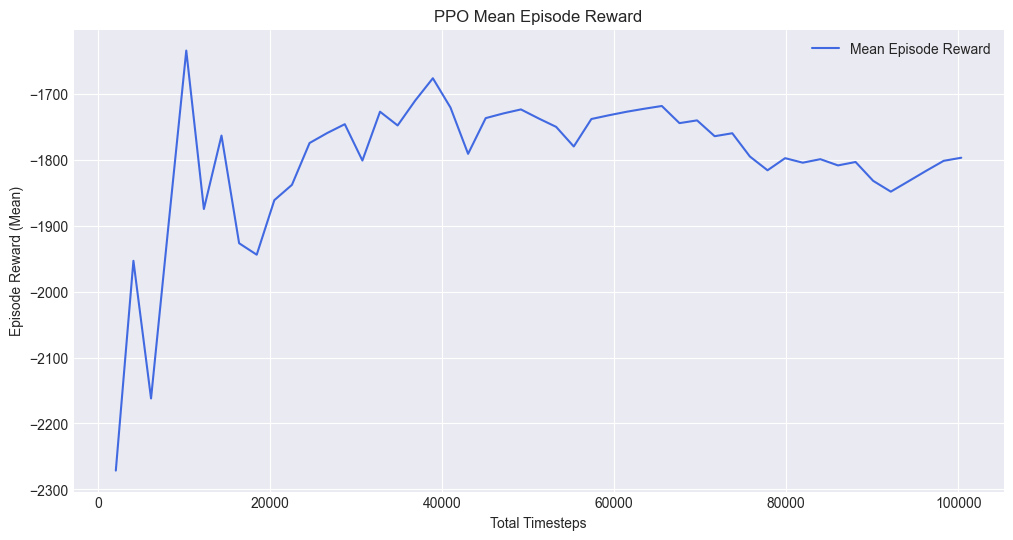

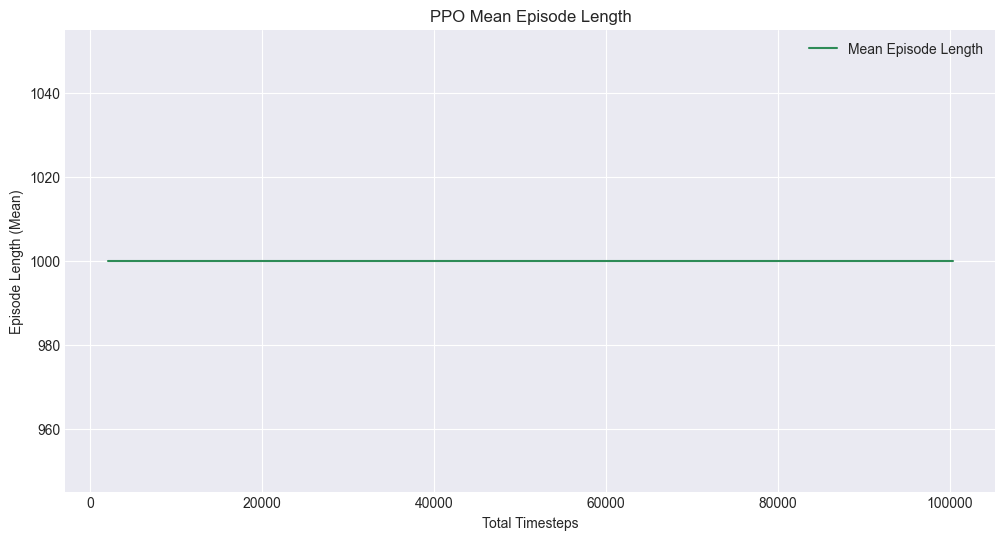

In [117]:
# Plot: Mean Episode Reward vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs['time/total_timesteps'], logs['rollout/ep_rew_mean'], label='Mean Episode Reward', color='royalblue')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Reward (Mean)')
plt.title('PPO Mean Episode Reward')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Episode Length vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs['time/total_timesteps'], logs['rollout/ep_len_mean'], label='Mean Episode Length', color='seagreen')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Length (Mean)')
plt.title('PPO Mean Episode Length')
plt.grid(True)
plt.legend()
plt.show()

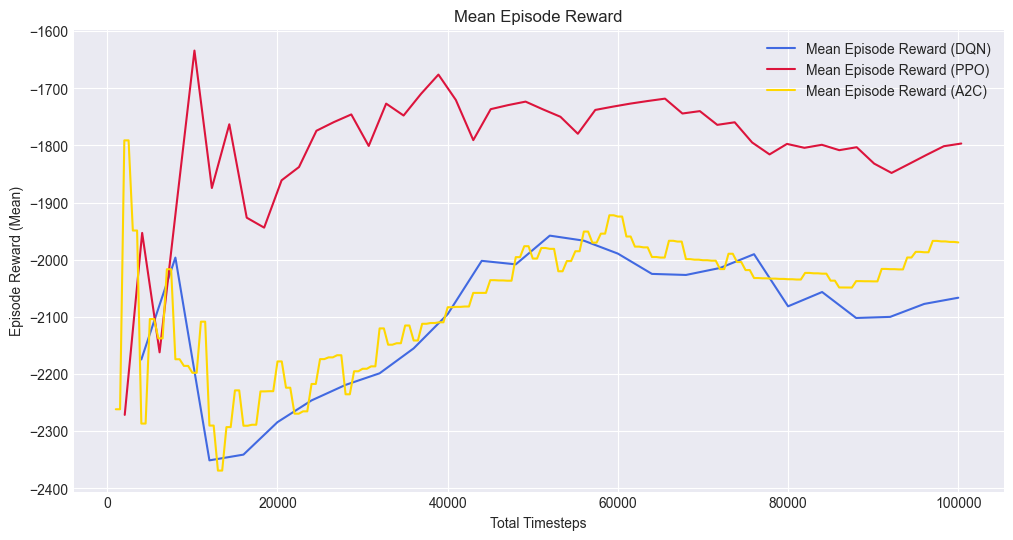

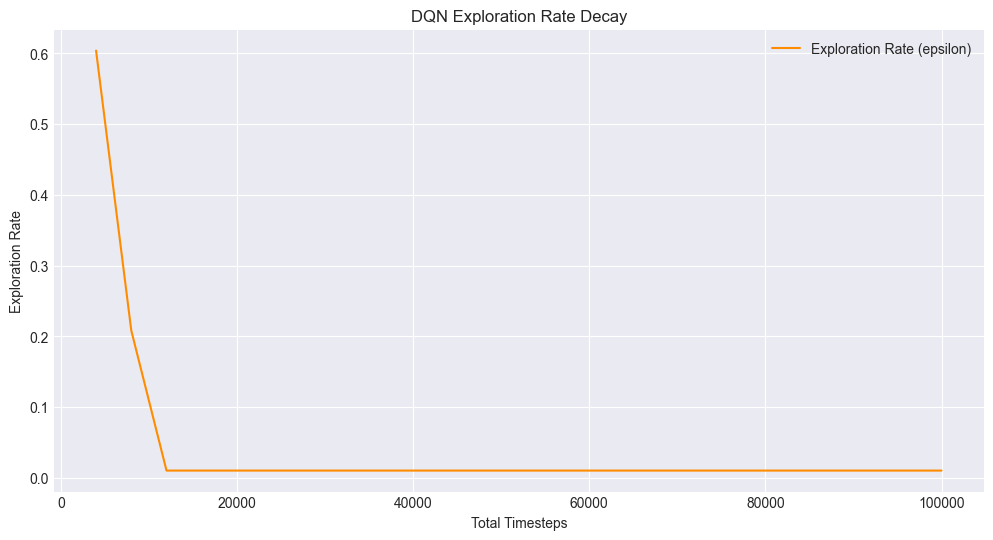

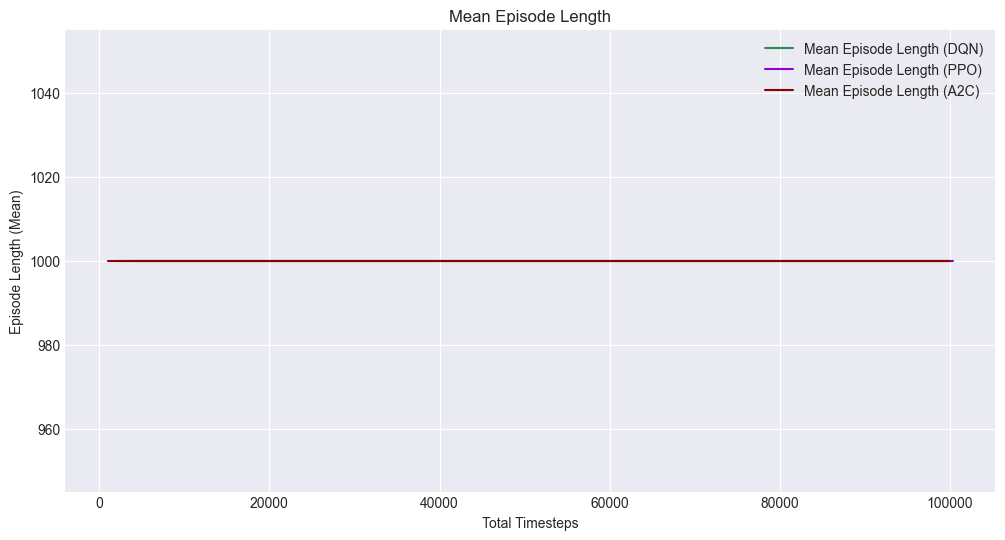

In [118]:
# Filter for first 40,000 timesteps
logs_dqn =  pd.read_csv('./dqn/logs/progress.csv')
logs_ppo = pd.read_csv('./ppo/logs/progress.csv')
logs_a2c = pd.read_csv('./a2c/logs/progress.csv')

# Plot: Mean Episode Reward vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs_dqn['time/total_timesteps'], logs_dqn['rollout/ep_rew_mean'], label='Mean Episode Reward (DQN)', color='royalblue')
plt.plot(logs_ppo['time/total_timesteps'], logs_ppo['rollout/ep_rew_mean'], label='Mean Episode Reward (PPO)', color='crimson')
plt.plot(logs_a2c['time/total_timesteps'], logs_a2c['rollout/ep_rew_mean'], label='Mean Episode Reward (A2C)', color='gold')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Reward (Mean)')
plt.title('Mean Episode Reward')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Exploration Rate vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs_dqn['time/total_timesteps'], logs_dqn['rollout/exploration_rate'], label='Exploration Rate (epsilon)', color='darkorange')
plt.xlabel('Total Timesteps')
plt.ylabel('Exploration Rate')
plt.title('DQN Exploration Rate Decay')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Episode Length vs. Timesteps
plt.figure(figsize=(12, 6))
plt.plot(logs_dqn['time/total_timesteps'], logs_dqn['rollout/ep_len_mean'], label='Mean Episode Length (DQN)', color='seagreen')
plt.plot(logs_ppo['time/total_timesteps'], logs_ppo['rollout/ep_len_mean'], label='Mean Episode Length (PPO)', color='darkviolet')
plt.plot(logs_a2c['time/total_timesteps'], logs_a2c['rollout/ep_len_mean'], label='Mean Episode Length (A2C)', color='darkred')
plt.xlabel('Total Timesteps')
plt.ylabel('Episode Length (Mean)')
plt.title('Mean Episode Length')
plt.grid(True)
plt.legend()
plt.show()


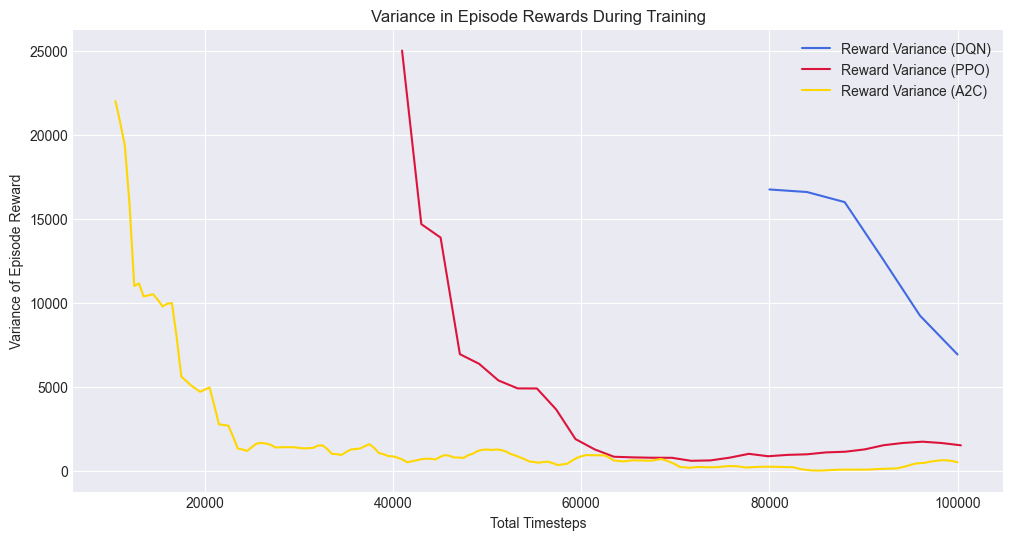

In [119]:
# Convert logs to DataFrames if they aren't already
logs_dqn_df = pd.DataFrame(logs_dqn)
logs_ppo_df = pd.DataFrame(logs_ppo)
logs_a2c_df = pd.DataFrame(logs_a2c)

# Calculate rolling variance (optional: adjust window size)
window_size = 20
var_dqn = logs_dqn_df['rollout/ep_rew_mean'].rolling(window=window_size).var()
var_ppo = logs_ppo_df['rollout/ep_rew_mean'].rolling(window=window_size).var()
var_a2c = logs_a2c_df['rollout/ep_rew_mean'].rolling(window=window_size).var()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(logs_dqn_df['time/total_timesteps'], var_dqn, label='Reward Variance (DQN)', color='royalblue')
plt.plot(logs_ppo_df['time/total_timesteps'], var_ppo, label='Reward Variance (PPO)', color='crimson')
plt.plot(logs_a2c_df['time/total_timesteps'], var_a2c, label='Reward Variance (A2C)', color='gold')
plt.xlabel('Total Timesteps')
plt.ylabel('Variance of Episode Reward')
plt.title('Variance in Episode Rewards During Training')
plt.grid(True)
plt.legend()
plt.show()


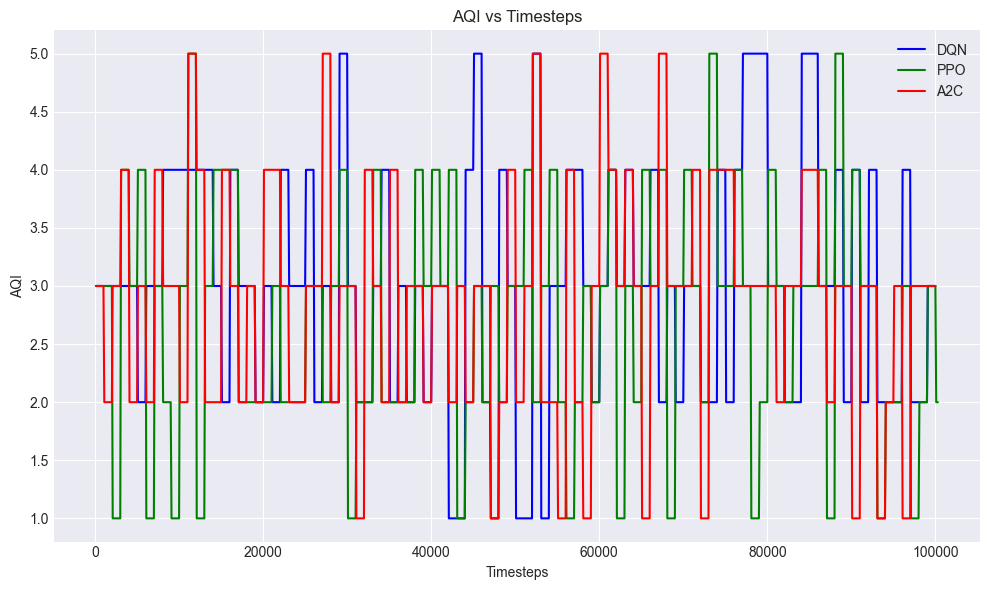

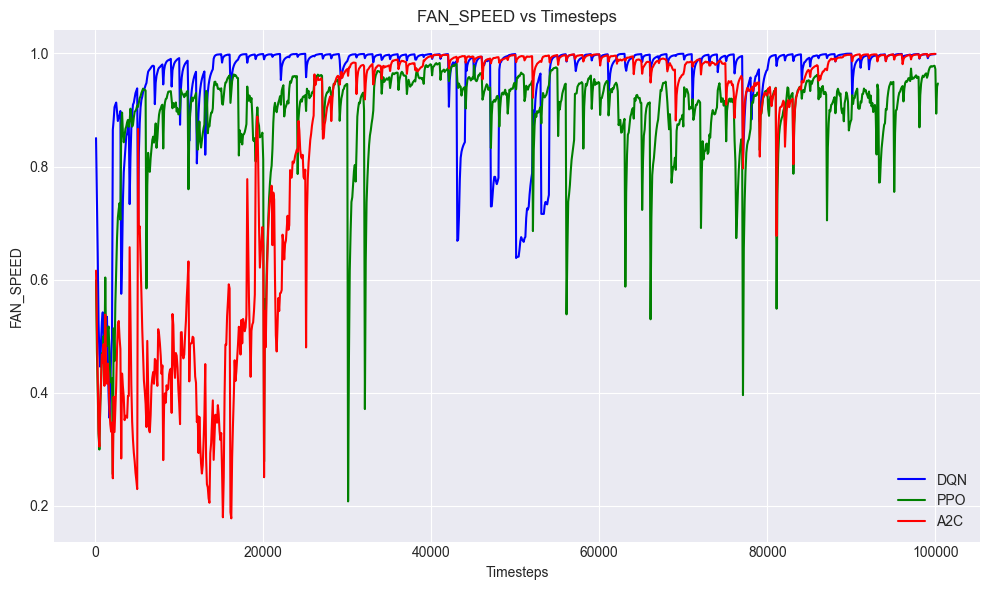

In [120]:
# Load the data
metrics_dqn = pd.read_csv('./dqn/train/training_metrics.csv')
metrics_ppo = pd.read_csv('./ppo/train/training_metrics.csv')
metrics_a2c = pd.read_csv('./a2c/train/training_metrics.csv')

# Define the metrics to plot
metrics = ['aqi','fan_speed']

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')

# Create a plot for each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(metrics_dqn['timestep'], metrics_dqn[metric], label='DQN', color='blue')
    plt.plot(metrics_ppo['timestep'], metrics_ppo[metric], label='PPO', color='green')
    plt.plot(metrics_a2c['timestep'], metrics_a2c[metric], label='A2C', color='red')
    
    plt.title(f'{metric.upper()} vs Timesteps')
    plt.xlabel('Timesteps')
    plt.ylabel(metric.upper())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [149]:

import sys
import os
from stable_baselines3 import PPO, DQN, A2C
from simulated.environment import FanControlGymEnv
import time
from simulated.physics import FanControlEnv
import matplotlib.pyplot as plt
import numpy as np

In [150]:

# 1. Load Environment and Model
fan_env = FanControlEnv()
env = FanControlGymEnv(fan_env=fan_env)

In [151]:
CHECKPOINT_DIR_DQN = './dqn/train'
CHECKPOINT_DIR_PPO = './ppo/train'
CHECKPOINT_DIR_A2C = './a2c/train'
CHECKPOINT_DIR_DQN2 = './dqn2/train'
CHECKPOINT_DIR_PPO2 = './ppo2/train'

In [155]:
# Define ranges
aqi_range = np.linspace(1.0, 5.0, 20)
# Truncate fan speeds below 0.53
speed_range = np.linspace(0.53, 1.0, 20)
action_grid = np.zeros((len(aqi_range), len(speed_range)))

In [153]:
def normalize_energy(fan_speed, fan_env):
    rpm = fan_speed * fan_env.max_rpm
    load_factor = min(rpm / fan_env.max_rpm, 0.95)
    current = fan_env.no_load_current + (fan_env.stall_current - fan_env.no_load_current) * (1 - load_factor)
    power = fan_env.voltage * current
    max_power = fan_env.stall_current * fan_env.voltage
    return min(power / max_power, 1.0)


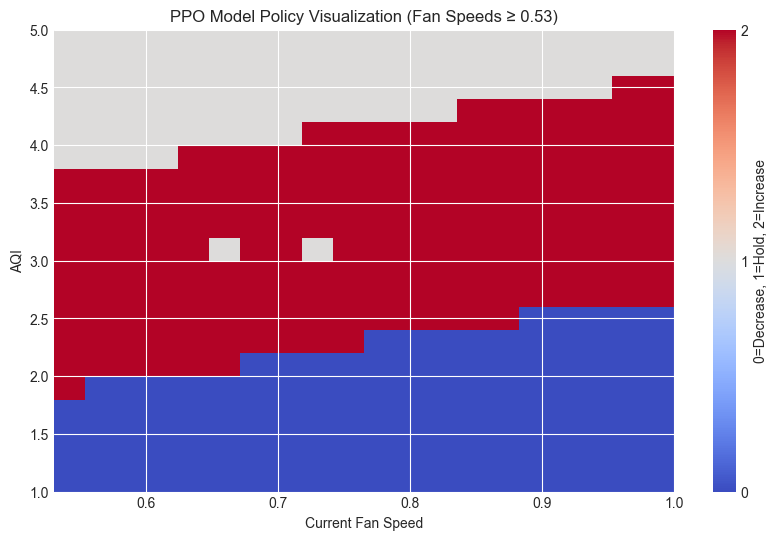

In [161]:
'''
Test with trained model
This script will load the trained model and run it in the environment to see how it performs.
'''

model_ppo = PPO.load(f"{CHECKPOINT_DIR_PPO}/model_100000")  # Path to your saved model
model_dqn = DQN.load(f"{CHECKPOINT_DIR_DQN}/model_100000")  # Path to your saved model
model_a2c = A2C.load(f"{CHECKPOINT_DIR_A2C}/model_100000")  # Path to your saved model
model_dqn2 = DQN.load(f"{CHECKPOINT_DIR_DQN2}/model_100000")  # Path to your saved model
model_ppo2 = PPO.load(f"{CHECKPOINT_DIR_PPO2}/model_100000")  # Path to your saved model
# Evaluate policy
for i, aqi in enumerate(aqi_range):
    for j, speed in enumerate(speed_range):
        obs = np.array([aqi, speed], dtype=np.float32)
        action, _ = model_dqn2.predict(obs)
        action_grid[i, j] = action

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(action_grid, extent=[0.53, 1.0, 1, 5], aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(ticks=[0, 1, 2], label='0=Decrease, 1=Hold, 2=Increase')
plt.xlabel('Current Fan Speed')
plt.ylabel('AQI')
plt.title('PPO Model Policy Visualization (Fan Speeds ≥ 0.53)')
plt.grid(True)
plt.show()

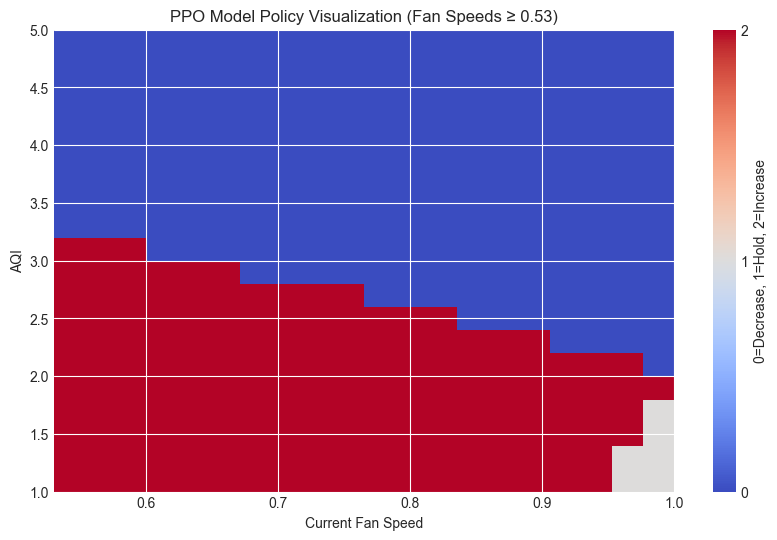

In [163]:
'''
Test with trained model
This script will load the trained model and run it in the environment to see how it performs.
'''
for i, aqi in enumerate(aqi_range):
    for j, speed in enumerate(speed_range):
        obs = np.array([aqi, speed], dtype=np.float32)
        action, _ = model_dqn.predict(obs)
        action_grid[i, j] = action

# Plot
plt.figure(figsize=(10, 6))
plt.imshow(action_grid, extent=[0.53, 1.0, 1, 5], aspect='auto', cmap='coolwarm', origin='lower')
plt.colorbar(ticks=[0, 1, 2], label='0=Decrease, 1=Hold, 2=Increase')
plt.xlabel('Current Fan Speed')
plt.ylabel('AQI')
plt.title('PPO Model Policy Visualization (Fan Speeds ≥ 0.53)')
plt.grid(True)
plt.show()

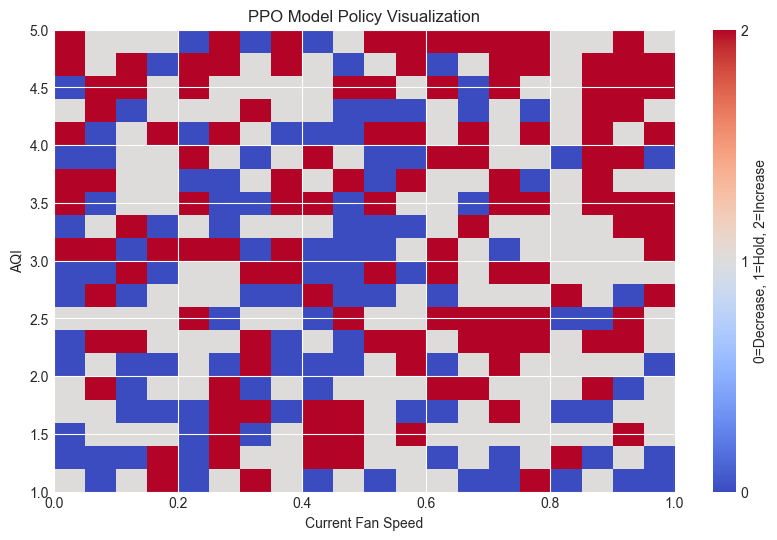

In [131]:
for i, aqi in enumerate(aqi_range):
    for j, speed in enumerate(speed_range):
        normalized_energy = normalize_energy(speed, fan_env)
        obs = np.array([aqi, speed], dtype=np.float32)
        action, _ = model_ppo.predict(obs)
        action_grid[i, j] = action

plt.figure(figsize=(10,6))
plt.imshow(action_grid, extent=[0,1,1,5], aspect='auto', cmap='coolwarm')
plt.colorbar(ticks=[0,1,2], label='0=Decrease, 1=Hold, 2=Increase')
plt.xlabel('Current Fan Speed')
plt.ylabel('AQI')
plt.title('PPO Model Policy Visualization')
plt.show()

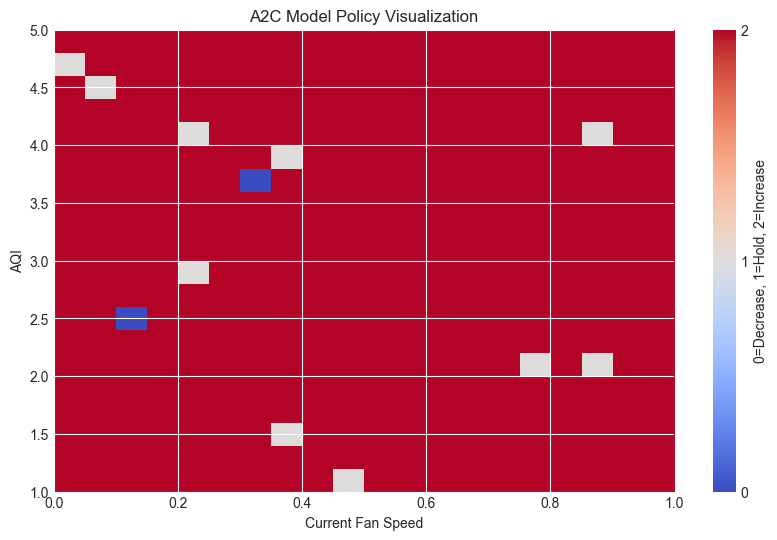

In [132]:
for i, aqi in enumerate(aqi_range):
    for j, speed in enumerate(speed_range):
        normalized_energy = normalize_energy(speed, fan_env)
        obs = np.array([aqi, speed], dtype=np.float32)
        action, _ = model_a2c.predict(obs)
        action_grid[i, j] = action

plt.figure(figsize=(10,6))
plt.imshow(action_grid, extent=[0,1,1,5], aspect='auto', cmap='coolwarm')
plt.colorbar(ticks=[0,1,2], label='0=Decrease, 1=Hold, 2=Increase')
plt.xlabel('Current Fan Speed')
plt.ylabel('AQI')
plt.title('A2C Model Policy Visualization')
plt.show()

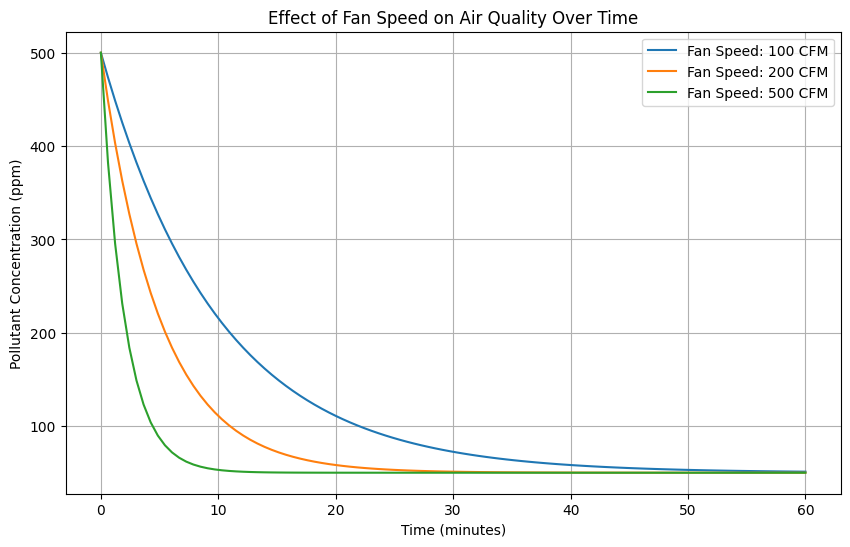

In [67]:
import numpy as np
import matplotlib.pyplot as plt

def air_quality_model(fan_speed, initial_pollution, room_volume, outdoor_air_quality, time):
    """
    Models air quality over time based on fan speed
    
    Parameters:
    - fan_speed: in CFM (cubic feet per minute) or similar unit
    - initial_pollution: initial concentration of pollutants (ppm or µg/m³)
    - room_volume: volume of the space (cubic feet or cubic meters)
    - outdoor_air_quality: background pollution level
    - time: array of time points to evaluate (minutes)
    
    Returns:
    - array of pollution concentrations over time
    """
    # Air exchange rate (how many room volumes per minute the fan moves)
    air_exchange_rate = fan_speed / room_volume
    
    pollution = np.zeros_like(time, dtype=float)
    pollution[0] = initial_pollution
    
    for i in range(1, len(time)):
        dt = time[i] - time[i-1]
        # Simple exponential decay model
        pollution[i] = outdoor_air_quality + (pollution[i-1] - outdoor_air_quality) * np.exp(-air_exchange_rate * dt)
    
    return pollution

# Example usage
room_volume = 1000  # cubic feet
fan_speeds = [100, 200, 500]  # CFM
initial_pollution = 500  # ppm
outdoor_air_quality = 50  # ppm
time = np.linspace(0, 60, 100)  # 60 minutes

plt.figure(figsize=(10, 6))
for speed in fan_speeds:
    pollution = air_quality_model(speed, initial_pollution, room_volume, outdoor_air_quality, time)
    plt.plot(time, pollution, label=f'Fan Speed: {speed} CFM')

plt.xlabel('Time (minutes)')
plt.ylabel('Pollutant Concentration (ppm)')
plt.title('Effect of Fan Speed on Air Quality Over Time')
plt.legend()
plt.grid(True)
plt.show()

Step:    1 | AQI: 3.16 | Fan: 0.33 (6116 RPM) | Power: 109.8W
Step:    2 | AQI: 3.13 | Fan: 0.33 (6116 RPM) | Power: 109.8W
Step:    3 | AQI: 3.06 | Fan: 0.43 (7991 RPM) | Power: 95.2W
Step:    4 | AQI: 2.99 | Fan: 0.43 (7991 RPM) | Power: 95.2W
Step:    5 | AQI: 3.05 | Fan: 0.43 (7991 RPM) | Power: 95.2W
Step:    6 | AQI: 3.05 | Fan: 0.33 (6116 RPM) | Power: 109.8W
Step:    7 | AQI: 3.04 | Fan: 0.23 (4241 RPM) | Power: 124.4W
Step:    8 | AQI: 3.03 | Fan: 0.33 (6116 RPM) | Power: 109.8W
Step:    9 | AQI: 3.05 | Fan: 0.23 (4241 RPM) | Power: 124.4W
Step:   10 | AQI: 2.95 | Fan: 0.23 (4241 RPM) | Power: 124.4W
Step:   11 | AQI: 2.91 | Fan: 0.23 (4241 RPM) | Power: 124.4W
Step:   12 | AQI: 2.87 | Fan: 0.13 (2366 RPM) | Power: 139.0W
Step:   13 | AQI: 2.81 | Fan: 0.23 (4241 RPM) | Power: 124.4W
Step:   14 | AQI: 2.80 | Fan: 0.23 (4241 RPM) | Power: 124.4W
Step:   15 | AQI: 2.74 | Fan: 0.23 (4241 RPM) | Power: 124.4W
Step:   16 | AQI: 2.70 | Fan: 0.33 (6116 RPM) | Power: 109.8W
Step:   17 